Load the C. Elegans connectome. Downloaded from https://wormwiring.org/series/. Exported from chemicalmatrix.xlsx.

In [1]:
using LinearAlgebra;
using Test;

using CSV;
using DataFrames;
using DataFramesMeta;
using Plots;

using DataStructures;

gr()

table = CSV.read("chemicalmatrix_posterior.csv") |> DataFrame;
typeof(table)

DataFrame

Clean up the table.

In [2]:
# Rename columns
rename!(table, Dict(:Column2 => :group, 
                    :Column3 => :subgroup,
                    :Column4 => :neuron))
cols = [:group, :subgroup]

# Fill NA's with preceding values
lastvalid = Dict()
for col in cols
    lastvalid[col] = missing
end

for row in eachrow(table)
    for col in cols
        if row[col] === missing
            row[col] = lastvalid[col]
        else
            lastvalid[col] = row[col]
        end
    end
end

In [3]:
pre_neurons = table[5:size(table, 1) - 1, :neuron]
post_neurons = Vector(table[4, 5:length(pre_neurons) + 4]);
@assert post_neurons == pre_neurons

meta = table[5:size(table, 1) - 1, [:neuron, :group, :subgroup]]
connection_strength = table[5:size(table, 1) - 1, 5:length(pre_neurons) + 4]
@assert size(connection_strength, 1) == size(connection_strength, 2)

In [4]:
#names(connection_strength)[1]
#convert(Array{Union{Int, Missing}}, connection_strength.PHAL)
# Rename columns.
names!(connection_strength, Symbol.(post_neurons))

# Replace NA
for col in names(connection_strength)
    connection_strength[ismissing.(connection_strength[:, col]), col] = "0"
end

# Finally, obtain the data frame of the connection strengths.
df_C_T = parse.(Int, connection_strength);

┌ Warning: implicit broadcasting in setindex! is deprecated; use `df[row_inds, col_ind] .= Ref(v)` broadcasting assignment to change the column in place
│   caller = setindex!(::DataFrame, ::String, ::BitArray{1}, ::Symbol) at deprecated.jl:1490
└ @ DataFrames /home/pmin/.julia/packages/DataFrames/XuYBH/src/deprecated.jl:1490


Create a connection strength matrix the long way, by iterating through the dataframe.

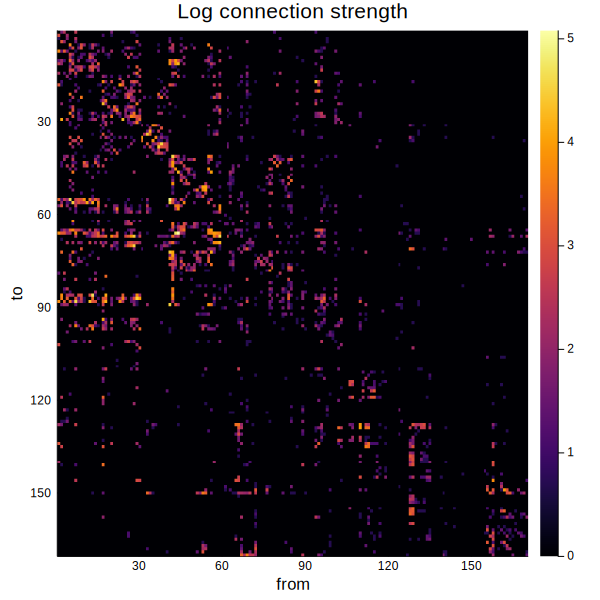

In [5]:
heatmap(transpose(log1p.(convert(Matrix, df_C_T))), size=(600, 600), yflip=:true)
title!("Log connection strength")
xlabel!("from")
ylabel!("to")

Look at how symmetric the weight matrix is.

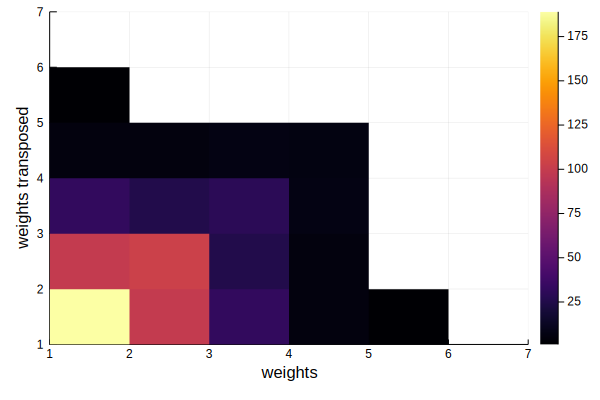

In [6]:
C_T = convert(Matrix, df_C_T)
C = transpose(C_T)
C_ = reshape(transpose(C_T), length(C_T))
C_T_ = reshape(C_T, length(C_T));

histogram2d(log1p.(C_), log1p.(C_T_), bins=1:7)
xlabel!("weights")
ylabel!("weights transposed")

In [7]:
using Statistics;

good_idx = (C_ .!= 0) .& (C_T_ .!= 0)
cor(hcat(C_[good_idx], C_T_[good_idx]))
#sum(good_idx)

2×2 Array{Float64,2}:
 1.0       0.266513
 0.266513  1.0     

The weight matrix is not very symmetric.

# Find hubs in the data using PageRank

Do this using the non-binarized connection matrix.

In [8]:
alpha = .85
total_degree = sum(C, dims=1)
total_degree[total_degree .== 0] .= 1

Lambda = (C ./ (reshape(total_degree, (1, length(total_degree)))))

# Make sure that we've normalized properly.

# If we've normalized properly, it follows that for every node, the sum of the out nodes is 1.0
# i.e. sum(Lambda[:, i]) == 1 \forall i (unless it's equal to 0 because there are no outgoing nodes)
sums = sum(Lambda, dims=1);
@assert all(isapprox.(sums, 1.0) .| isapprox.(sums, 0.0))

x_star = sum(inv(I - alpha * Lambda), dims=2);

In [9]:
#annotategroups(meta)

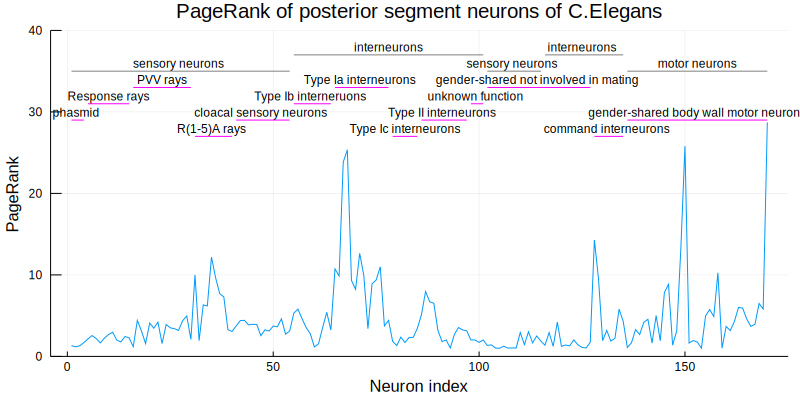

In [10]:
function annotategroups!(meta, ypos=0)
    # Join similar metadata groups together
    group = missing
    subgroup = missing
    
    groups = []
    subgroups = []
    
    group_start = 1
    subgroup_start = 1
    for (i, row) in enumerate(eachrow(meta))
        if group !== row.group
            if i > 1
                push!(groups, (group, group_start, i - 1))
            end
            group_start = i
        end
        group = row.group
        
        if subgroup !== row.subgroup
            if i > 1
                push!(subgroups, (subgroup, subgroup_start, i - 1))
            end
            subgroup_start = i
        end
        subgroup = row.subgroup
    end
    
    push!(groups, (group, group_start, size(meta, 1)))
    push!(subgroups, (subgroup, subgroup_start, size(meta, 1)))
    
    i = 1
    heights = 4
    dh = 2
    for (name, s, e) in subgroups
        annotate!([((s + e) ÷ 2, 
                    ypos + (i % heights) * dh + .2, 
                    text(name, 8, :blue, :center, :bottom))])
        plot!([s, e], 
            [ypos + (i % heights) * dh, 
             ypos + (i % heights) * dh], c=:magenta)
        i += 1
    end
    
    for (name, s, e) in groups
        annotate!([((s + e) ÷ 2, 
                    ypos + ((i % 2) + heights) * dh + .2, 
                    text(name, 8, :blue, :center, :bottom))])
        plot!([s, e], 
            [ypos + ((i % 2) + heights) * dh, 
             ypos + ((i % 2) + heights) * dh], c=:gray)
        i += 1
    end
    
end

plot(x_star, size=(800, 400), legend=:false);
ylims!((0, 40))
annotategroups!(meta, 27);
xlabel!("Neuron index")
ylabel!("PageRank")
title!("PageRank of posterior segment neurons of C.Elegans")

# Look at the bowtie plot of the data

In [11]:
# TODO

# Find communities in the data

In [12]:
# TODO